In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, cv, Pool
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from typing import List, Dict
import matplotlib.pyplot as plt

In [3]:
# генератор метрик
def eval_metrics(y_test: pd.DataFrame, y_pred: pd.DataFrame, verbose: bool) -> List[float]:
    """
    :param y_test: test dataset
    :param y_pred: predicted dataset
    :param verbose: print scores flag
    :return: list of scores [Precision Score, Recall Score, F1 Score, Accuracy Score, ROC AUC]
    """

    print(type(y_test), type(y_pred))
    pr_sc = round(precision_score(y_val, y_pred), 3)
    re_sc = round(recall_score(y_val, y_pred), 3)
    f1_sc = round(f1_score(y_val, y_pred), 3)
    ac_sc = round(accuracy_score(y_val, y_pred), 3)
    ra_sc = round(roc_auc_score(y_val, y_pred), 3)

    print('Precision Score: ', pr_sc)
    print('Recall Score: ', re_sc)
    print('F1 Score: ', f1_sc)
    print('Accuracy Score: ', ac_sc)
    print('ROC AUC: ', ra_sc)

    return [pr_sc, re_sc, f1_sc, ac_sc, ra_sc]

In [4]:
# предобработчик наборов данных
def load_datasets(X_filename: str, y_filename: str, X_val_filename: str, y_val_filename: str) -> List[pd.DataFrame]:
    """
    :param X_filename: path to csx with X data
    :param y_filename: path to csx with y data
    :param X_val_filename: path to csx with X_val data
    :param y_val_filename: path to csx with y_val data
    :return: list of pandas dataframes [X, y, X_val, y_val]
    """
    X = pd.read_csv(X_filename)
    y = pd.read_csv(y_filename)
    X_val = pd.read_csv(X_val_filename)
    y_val = pd.read_csv(y_val_filename)

    x_col_names = list(X.columns)
    x_col_names[0] = 'user_id'
    X.columns = x_col_names
    X_val.columns = x_col_names
    y = y.drop(columns=[list(y.columns)[0]])
    y_val = y_val.drop(columns=[list(y_val.columns)[0]])

    return [X, y, X_val, y_val]

In [5]:
# визуализация зависимости метрик от гиперпараметра "iterations"
def visualize_it(catboost_scores: pd.DataFrame) -> None:
    """
    :param catboost_scores: dataframe with index = iterations param value,
             metrics columns = ['Precision Score', 'Recall Score', 'F1 Score', 'Accuracy Score', 'ROC AUC']
    :return:
    """
    plt.figure(figsize=[15, 10])
    plt.plot(catboost_scores['Precision Score'], label=catboost_scores.columns[0])
    plt.plot(catboost_scores['Recall Score'], label=catboost_scores.columns[1])
    plt.plot(catboost_scores['F1 Score'], label=catboost_scores.columns[2])
    plt.plot(catboost_scores['Accuracy Score'], label=catboost_scores.columns[3])
    plt.plot(catboost_scores['ROC AUC'], label=catboost_scores.columns[4])
    plt.xlabel('Количество итераций (параметр "iterations")')
    plt.ylabel('Значение метрики')
    plt.title('Зависимость метрик качества от гиперпараметра "iterations"')
    plt.legend()
    plt.show()

In [6]:
# непосредственно catboost
def catboost_it(X: pd.DataFrame, y: pd.DataFrame, X_val: pd.DataFrame, y_val: pd.DataFrame, min_iterations: int,
                max_iterations: int, iteration_step: int, verbose: bool, category_columns: List[str]) -> pd.DataFrame:
    """
    :param iteration_step:
    :param category_columns:
    :param X: training set of values
    :param y: training set of results
    :param X_val: test set of values
    :param y_val: test set of results
    :param min_iterations: minimum value of catboost's iterations parameter
    :param max_iterations: max value of catboost's iterations parameter
    :param verbose: is needed to show iteration info
    :return: dataframe with index = iterations param value,
             metrics columns = ['Precision Score', 'Recall Score', 'F1 Score', 'Accuracy Score', 'ROC AUC']
    """
    if category_columns is None:
        category_columns = []
    else:
        for cat in category_columns:
            X[cat] = X[cat].astype(str)
    catboost_boost_results = dict()
    for i in range(min_iterations, max_iterations, iteration_step):
        catboost_model = CatBoostClassifier(iterations=i + 1, eval_metric='AUC', cat_features=category_columns,
                                            learning_rate=0.1)
        print(catboost_model.feature_names_)
        catboost_model.fit(X, y, cat_features=category_columns, eval_set=(X_val, y_val), plot=True)
        prediction = catboost_model.predict(X_val)
        prediction = np.array(prediction)
        prediction = prediction.astype('bool')
        print(prediction)
        catboost_boost_results[i + 1] = eval_metrics(y_val, prediction, verbose)

    catboost_scores = pd.DataFrame(catboost_boost_results).T
    catboost_scores.columns = ['Precision Score', 'Recall Score', 'F1 Score', 'Accuracy Score', 'ROC AUC']

    return catboost_scores

## Набор данных "Первая итерация"

In [7]:
# загружаем данные
X, y, X_val, y_val = load_datasets('0_X.csv', '0_y.csv', '0_X_val.csv', '0_y_val.csv')

In [8]:
X

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
0,957056,12.0,18.0,-0.638518,-0.718161,-0.718841,-0.718706,-0.747321,-0.252563,-0.315014,-0.377476,-0.332739,0.000000,0.000000,0.446632,0.000000
1,536962,8.0,24.0,-0.708945,-0.793489,-0.699894,-0.699898,-0.747321,-0.249717,-0.313873,-0.450555,0.000000,0.000000,-0.220128,0.581223,0.000000
2,1575854,0.0,24.0,0.002368,1.541680,0.190890,0.190749,1.702509,0.028720,-0.212311,-0.236189,0.454859,0.000000,0.000000,-0.091734,1.363902
3,1543057,9.0,24.0,0.699596,0.110447,0.698418,0.698556,0.613696,-0.252563,0.355982,-0.338500,-0.316987,-0.208879,0.000000,1.433635,-0.267198
4,1520724,14.0,24.0,-0.596262,-0.416849,-0.586770,-0.586634,-0.407067,-0.186736,-0.273933,-0.401836,-0.316987,0.000000,0.000000,0.715815,-0.593418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723233,73349,14.0,24.0,0.122094,-0.115537,0.206633,0.206631,0.001238,0.017487,-0.315014,-0.012078,0.785650,0.000000,0.000000,-0.271189,-0.348753
1723234,836489,11.0,24.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.251140,-0.292191,0.000000,0.000000,0.000000,0.000000,-1.123601,0.000000
1723235,491263,0.0,24.0,-0.004674,-0.040209,0.067875,0.067872,-0.134863,0.000000,-0.295615,-0.002334,0.360347,0.000000,0.000000,-0.226325,0.222132
1723236,491755,14.0,1.0,0.000000,0.000000,-0.767462,-0.767605,-0.883422,-0.252563,-0.313873,0.000000,0.000000,0.000000,0.000000,-0.989009,0.000000


In [9]:
y

,CHURN
0,0
1,0
2,0
3,0
4,0
...,...
1723233,1
1723234,0
1723235,0
1723236,1


In [10]:
X['REGION'] = X['REGION'].apply(int)
X_val['REGION'] = X_val['REGION'].apply(int)
X['TENURE'] = X['TENURE'].apply(int)
X_val['TENURE'] = X_val['TENURE'].apply(int)
catboost_model = CatBoostClassifier(max_depth=6, eval_metric='AUC', reg_lambda=370,
                                             cat_features=['REGION', 'TENURE'])
catboost_model.fit(X, y)
predict = catboost_model.predict(X_val)
print(f'ROC AUC:\n{round(roc_auc_score(y_val, predict), 3)}')


0:	total: 1.02s	remaining: 17m 3s
1:	total: 1.67s	remaining: 13m 55s
2:	total: 2.46s	remaining: 13m 36s
3:	total: 3.2s	remaining: 13m 16s
4:	total: 3.88s	remaining: 12m 52s
5:	total: 4.57s	remaining: 12m 36s
6:	total: 5.21s	remaining: 12m 18s
7:	total: 5.92s	remaining: 12m 14s
8:	total: 6.58s	remaining: 12m 5s
9:	total: 7.21s	remaining: 11m 54s
10:	total: 7.83s	remaining: 11m 44s
11:	total: 8.39s	remaining: 11m 30s
12:	total: 9.04s	remaining: 11m 26s
13:	total: 9.71s	remaining: 11m 24s
14:	total: 10.4s	remaining: 11m 20s
15:	total: 11s	remaining: 11m 17s
16:	total: 11.6s	remaining: 11m 10s
17:	total: 12.4s	remaining: 11m 15s
18:	total: 13.1s	remaining: 11m 14s
19:	total: 13.7s	remaining: 11m 13s
20:	total: 14.4s	remaining: 11m 9s
21:	total: 15s	remaining: 11m 8s
22:	total: 15.8s	remaining: 11m 10s
23:	total: 16.6s	remaining: 11m 17s
24:	total: 17.5s	remaining: 11m 21s
25:	total: 18.4s	remaining: 11m 27s
26:	total: 19.2s	remaining: 11m 33s
27:	total: 19.9s	remaining: 11m 30s
28:	total: 

In [11]:
catboost_scores = catboost_it(X, y, X_val, y_val, 1, 100, 10, True, ['REGION', 'TENURE'])
catboost_scores

None


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8813846	best: 0.8813846 (0)	total: 254ms	remaining: 254ms
1:	test: 0.8948843	best: 0.8948843 (1)	total: 467ms	remaining: 0us

bestTest = 0.8948843323
bestIteration = 1

[False False False ... False False False]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
Precision Score:  0.66
Recall Score:  0.556
F1 Score:  0.603
Accuracy Score:  0.863
ROC AUC:  0.745
None


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8813846	best: 0.8813846 (0)	total: 240ms	remaining: 2.64s
1:	test: 0.8948843	best: 0.8948843 (1)	total: 437ms	remaining: 2.18s
2:	test: 0.8947368	best: 0.8948843 (1)	total: 632ms	remaining: 1.9s
3:	test: 0.8956326	best: 0.8956326 (3)	total: 787ms	remaining: 1.57s
4:	test: 0.8959789	best: 0.8959789 (4)	total: 942ms	remaining: 1.32s
5:	test: 0.8967732	best: 0.8967732 (5)	total: 1.1s	remaining: 1.1s
6:	test: 0.8970815	best: 0.8970815 (6)	total: 1.25s	remaining: 896ms
7:	test: 0.8975363	best: 0.8975363 (7)	total: 1.41s	remaining: 706ms
8:	test: 0.8975071	best: 0.8975363 (7)	total: 1.56s	remaining: 522ms
9:	test: 0.8974703	best: 0.8975363 (7)	total: 1.72s	remaining: 344ms
10:	test: 0.8974076	best: 0.8975363 (7)	total: 1.87s	remaining: 170ms
11:	test: 0.8974201	best: 0.8975363 (7)	total: 2.03s	remaining: 0us

bestTest = 0.8975362874
bestIteration = 7

Shrink model to first 8 iterations.
[False False False ... False False False]
<class 'pandas.core.frame.DataFrame'> <class 'numpy.n

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8813846	best: 0.8813846 (0)	total: 252ms	remaining: 5.3s
1:	test: 0.8948843	best: 0.8948843 (1)	total: 462ms	remaining: 4.62s
2:	test: 0.8947368	best: 0.8948843 (1)	total: 656ms	remaining: 4.15s
3:	test: 0.8956326	best: 0.8956326 (3)	total: 812ms	remaining: 3.65s
4:	test: 0.8959789	best: 0.8959789 (4)	total: 967ms	remaining: 3.29s
5:	test: 0.8967732	best: 0.8967732 (5)	total: 1.12s	remaining: 2.99s
6:	test: 0.8970815	best: 0.8970815 (6)	total: 1.28s	remaining: 2.75s
7:	test: 0.8975363	best: 0.8975363 (7)	total: 1.44s	remaining: 2.52s
8:	test: 0.8975071	best: 0.8975363 (7)	total: 1.6s	remaining: 2.31s
9:	test: 0.8974703	best: 0.8975363 (7)	total: 1.75s	remaining: 2.1s
10:	test: 0.8974076	best: 0.8975363 (7)	total: 1.9s	remaining: 1.9s
11:	test: 0.8974201	best: 0.8975363 (7)	total: 2.05s	remaining: 1.71s
12:	test: 0.8973962	best: 0.8975363 (7)	total: 2.21s	remaining: 1.53s
13:	test: 0.9089395	best: 0.9089395 (13)	total: 2.38s	remaining: 1.36s
14:	test: 0.9146248	best: 0.914624

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8813846	best: 0.8813846 (0)	total: 245ms	remaining: 7.59s
1:	test: 0.8948843	best: 0.8948843 (1)	total: 444ms	remaining: 6.66s
2:	test: 0.8947368	best: 0.8948843 (1)	total: 633ms	remaining: 6.12s
3:	test: 0.8956326	best: 0.8956326 (3)	total: 789ms	remaining: 5.52s
4:	test: 0.8959789	best: 0.8959789 (4)	total: 943ms	remaining: 5.09s
5:	test: 0.8967732	best: 0.8967732 (5)	total: 1.1s	remaining: 4.75s
6:	test: 0.8970815	best: 0.8970815 (6)	total: 1.25s	remaining: 4.47s
7:	test: 0.8975363	best: 0.8975363 (7)	total: 1.41s	remaining: 4.22s
8:	test: 0.8975071	best: 0.8975363 (7)	total: 1.57s	remaining: 4s
9:	test: 0.8974703	best: 0.8975363 (7)	total: 1.72s	remaining: 3.79s
10:	test: 0.8974076	best: 0.8975363 (7)	total: 1.87s	remaining: 3.58s
11:	test: 0.8974201	best: 0.8975363 (7)	total: 2.03s	remaining: 3.38s
12:	test: 0.8973962	best: 0.8975363 (7)	total: 2.18s	remaining: 3.19s
13:	test: 0.9089395	best: 0.9089395 (13)	total: 2.36s	remaining: 3.03s
14:	test: 0.9146248	best: 0.91462

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8813846	best: 0.8813846 (0)	total: 237ms	remaining: 9.7s
1:	test: 0.8948843	best: 0.8948843 (1)	total: 424ms	remaining: 8.49s
2:	test: 0.8947368	best: 0.8948843 (1)	total: 615ms	remaining: 7.99s
3:	test: 0.8956326	best: 0.8956326 (3)	total: 767ms	remaining: 7.29s
4:	test: 0.8959789	best: 0.8959789 (4)	total: 923ms	remaining: 6.83s
5:	test: 0.8967732	best: 0.8967732 (5)	total: 1.07s	remaining: 6.43s
6:	test: 0.8970815	best: 0.8970815 (6)	total: 1.23s	remaining: 6.13s
7:	test: 0.8975363	best: 0.8975363 (7)	total: 1.38s	remaining: 5.86s
8:	test: 0.8975071	best: 0.8975363 (7)	total: 1.53s	remaining: 5.62s
9:	test: 0.8974703	best: 0.8975363 (7)	total: 1.68s	remaining: 5.37s
10:	test: 0.8974076	best: 0.8975363 (7)	total: 1.83s	remaining: 5.16s
11:	test: 0.8974201	best: 0.8975363 (7)	total: 1.99s	remaining: 4.96s
12:	test: 0.8973962	best: 0.8975363 (7)	total: 2.13s	remaining: 4.76s
13:	test: 0.9089395	best: 0.9089395 (13)	total: 2.31s	remaining: 4.62s
14:	test: 0.9146248	best: 0.91

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8813846	best: 0.8813846 (0)	total: 247ms	remaining: 12.6s
1:	test: 0.8948843	best: 0.8948843 (1)	total: 443ms	remaining: 11.1s
2:	test: 0.8947368	best: 0.8948843 (1)	total: 630ms	remaining: 10.3s
3:	test: 0.8956326	best: 0.8956326 (3)	total: 783ms	remaining: 9.4s
4:	test: 0.8959789	best: 0.8959789 (4)	total: 939ms	remaining: 8.83s
5:	test: 0.8967732	best: 0.8967732 (5)	total: 1.09s	remaining: 8.38s
6:	test: 0.8970815	best: 0.8970815 (6)	total: 1.25s	remaining: 8.03s
7:	test: 0.8975363	best: 0.8975363 (7)	total: 1.4s	remaining: 7.71s
8:	test: 0.8975071	best: 0.8975363 (7)	total: 1.56s	remaining: 7.45s
9:	test: 0.8974703	best: 0.8975363 (7)	total: 1.71s	remaining: 7.2s
10:	test: 0.8974076	best: 0.8975363 (7)	total: 1.86s	remaining: 6.95s
11:	test: 0.8974201	best: 0.8975363 (7)	total: 2.02s	remaining: 6.73s
12:	test: 0.8973962	best: 0.8975363 (7)	total: 2.17s	remaining: 6.51s
13:	test: 0.9089395	best: 0.9089395 (13)	total: 2.34s	remaining: 6.36s
14:	test: 0.9146248	best: 0.9146

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8813846	best: 0.8813846 (0)	total: 241ms	remaining: 14.7s
1:	test: 0.8948843	best: 0.8948843 (1)	total: 441ms	remaining: 13.2s
2:	test: 0.8947368	best: 0.8948843 (1)	total: 628ms	remaining: 12.4s
3:	test: 0.8956326	best: 0.8956326 (3)	total: 785ms	remaining: 11.4s
4:	test: 0.8959789	best: 0.8959789 (4)	total: 941ms	remaining: 10.7s
5:	test: 0.8967732	best: 0.8967732 (5)	total: 1.1s	remaining: 10.3s
6:	test: 0.8970815	best: 0.8970815 (6)	total: 1.25s	remaining: 9.85s
7:	test: 0.8975363	best: 0.8975363 (7)	total: 1.41s	remaining: 9.49s
8:	test: 0.8975071	best: 0.8975363 (7)	total: 1.56s	remaining: 9.18s
9:	test: 0.8974703	best: 0.8975363 (7)	total: 1.71s	remaining: 8.89s
10:	test: 0.8974076	best: 0.8975363 (7)	total: 1.85s	remaining: 8.6s
11:	test: 0.8974201	best: 0.8975363 (7)	total: 2s	remaining: 8.33s
12:	test: 0.8973962	best: 0.8975363 (7)	total: 2.15s	remaining: 8.09s
13:	test: 0.9089395	best: 0.9089395 (13)	total: 2.31s	remaining: 7.93s
14:	test: 0.9146248	best: 0.914624

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8813846	best: 0.8813846 (0)	total: 247ms	remaining: 17.5s
1:	test: 0.8948843	best: 0.8948843 (1)	total: 447ms	remaining: 15.6s
2:	test: 0.8947368	best: 0.8948843 (1)	total: 629ms	remaining: 14.5s
3:	test: 0.8956326	best: 0.8956326 (3)	total: 777ms	remaining: 13.2s
4:	test: 0.8959789	best: 0.8959789 (4)	total: 927ms	remaining: 12.4s
5:	test: 0.8967732	best: 0.8967732 (5)	total: 1.08s	remaining: 11.9s
6:	test: 0.8970815	best: 0.8970815 (6)	total: 1.23s	remaining: 11.4s
7:	test: 0.8975363	best: 0.8975363 (7)	total: 1.38s	remaining: 11s
8:	test: 0.8975071	best: 0.8975363 (7)	total: 1.52s	remaining: 10.7s
9:	test: 0.8974703	best: 0.8975363 (7)	total: 1.66s	remaining: 10.3s
10:	test: 0.8974076	best: 0.8975363 (7)	total: 1.81s	remaining: 10.1s
11:	test: 0.8974201	best: 0.8975363 (7)	total: 1.96s	remaining: 9.78s
12:	test: 0.8973962	best: 0.8975363 (7)	total: 2.1s	remaining: 9.54s
13:	test: 0.9089395	best: 0.9089395 (13)	total: 2.27s	remaining: 9.39s
14:	test: 0.9146248	best: 0.9146

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8813846	best: 0.8813846 (0)	total: 244ms	remaining: 19.8s
1:	test: 0.8948843	best: 0.8948843 (1)	total: 448ms	remaining: 17.9s
2:	test: 0.8947368	best: 0.8948843 (1)	total: 641ms	remaining: 16.9s
3:	test: 0.8956326	best: 0.8956326 (3)	total: 793ms	remaining: 15.5s
4:	test: 0.8959789	best: 0.8959789 (4)	total: 943ms	remaining: 14.5s
5:	test: 0.8967732	best: 0.8967732 (5)	total: 1.09s	remaining: 13.9s
6:	test: 0.8970815	best: 0.8970815 (6)	total: 1.24s	remaining: 13.3s
7:	test: 0.8975363	best: 0.8975363 (7)	total: 1.39s	remaining: 12.8s
8:	test: 0.8975071	best: 0.8975363 (7)	total: 1.53s	remaining: 12.5s
9:	test: 0.8974703	best: 0.8975363 (7)	total: 1.68s	remaining: 12.1s
10:	test: 0.8974076	best: 0.8975363 (7)	total: 1.82s	remaining: 11.8s
11:	test: 0.8974201	best: 0.8975363 (7)	total: 1.97s	remaining: 11.5s
12:	test: 0.8973962	best: 0.8975363 (7)	total: 2.12s	remaining: 11.2s
13:	test: 0.9089395	best: 0.9089395 (13)	total: 2.28s	remaining: 11.1s
14:	test: 0.9146248	best: 0.9

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8813846	best: 0.8813846 (0)	total: 251ms	remaining: 22.9s
1:	test: 0.8948843	best: 0.8948843 (1)	total: 445ms	remaining: 20s
2:	test: 0.8947368	best: 0.8948843 (1)	total: 632ms	remaining: 18.7s
3:	test: 0.8956326	best: 0.8956326 (3)	total: 777ms	remaining: 17.1s
4:	test: 0.8959789	best: 0.8959789 (4)	total: 927ms	remaining: 16.1s
5:	test: 0.8967732	best: 0.8967732 (5)	total: 1.07s	remaining: 15.3s
6:	test: 0.8970815	best: 0.8970815 (6)	total: 1.22s	remaining: 14.8s
7:	test: 0.8975363	best: 0.8975363 (7)	total: 1.37s	remaining: 14.4s
8:	test: 0.8975071	best: 0.8975363 (7)	total: 1.52s	remaining: 14s
9:	test: 0.8974703	best: 0.8975363 (7)	total: 1.66s	remaining: 13.7s
10:	test: 0.8974076	best: 0.8975363 (7)	total: 1.81s	remaining: 13.3s
11:	test: 0.8974201	best: 0.8975363 (7)	total: 1.95s	remaining: 13s
12:	test: 0.8973962	best: 0.8975363 (7)	total: 2.09s	remaining: 12.7s
13:	test: 0.9089395	best: 0.9089395 (13)	total: 2.26s	remaining: 12.6s
14:	test: 0.9146248	best: 0.9146248

,Precision Score,Recall Score,F1 Score,Accuracy Score,ROC AUC
2,0.660,0.556,0.603,0.863,0.745
12,0.660,0.556,0.603,0.863,0.745
22,0.694,0.632,0.662,0.879,0.784
32,0.691,0.641,0.665,0.879,0.788
42,0.688,0.648,0.668,0.879,0.790
52,0.687,0.651,0.669,0.879,0.792
62,0.687,0.653,0.670,0.879,0.792
72,0.687,0.653,0.670,0.879,0.792
82,0.687,0.653,0.670,0.879,0.792
92,0.687,0.653,0.670,0.879,0.792


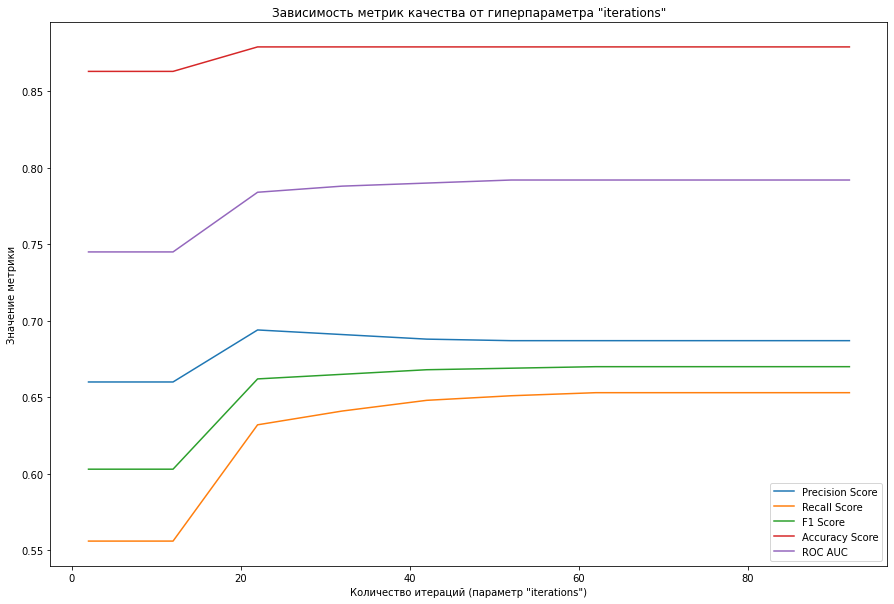

In [12]:
visualize_it(catboost_scores)

In [13]:
catboost_scores[catboost_scores['ROC AUC'] == catboost_scores['ROC AUC'].max()]

,Precision Score,Recall Score,F1 Score,Accuracy Score,ROC AUC
52,0.687,0.651,0.669,0.879,0.792
62,0.687,0.653,0.670,0.879,0.792
72,0.687,0.653,0.670,0.879,0.792
82,0.687,0.653,0.670,0.879,0.792
92,0.687,0.653,0.670,0.879,0.792


In [14]:
params = {
    'loss_function': 'Logloss',
    'iterations': 150,
    'custom_loss': 'AUC',
    'random_seed': 777
}

cv_data = cv(
    params=params,
    pool=Pool(X, label=y, cat_features=['REGION', 'TENURE']),
    fold_count=5,  # Разбивка выборки на 5
    shuffle=True,  # Перемешаем данные
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.2542052012
bestIteration = 149

Training on fold [1/5]

bestTest = 0.2524253134
bestIteration = 149

Training on fold [2/5]

bestTest = 0.2534809907
bestIteration = 149

Training on fold [3/5]

bestTest = 0.2533656902
bestIteration = 149

Training on fold [4/5]

bestTest = 0.2534307363
bestIteration = 149



## Набор данных "Вторая итерация"

In [34]:
full_df = pd.read_csv('iteration2.csv')
full_df = full_df.drop(columns=list(full_df.columns)[:1])
full_df

,user_id,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,...,REGION,TENURE,MONTANT/FREQUENCE_RECH,REVENUE/FREQUENCE_RECH,DATA_VOLUME/REGULARITY,ON_NET/REGULARITY,ORANGE/REGULARITY,TIGO/REGULARITY,ZONE1/REGULARITY,ZONE2/REGULARITY
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,...,FATICK,K > 24 month,283.333333,283.400000,0.074074,7.185185,0.851852,0.018519,0.018519,0.037037
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,OTHER,I 18-21 month,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,00001654a9d9f96303d9969d0a4a851714a4bb57,3600.0,2.0,1020.0,340.0,2.0,0.0,90.0,46.0,7.0,...,OTHER,K > 24 month,1800.000000,510.000000,0.000000,5.294118,2.705882,0.411765,0.000000,0.000000
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,...,DAKAR,K > 24 month,900.000000,900.133333,706.516129,0.661290,1.645161,0.032258,0.000000,0.000000
4,000028d9e13a595abe061f9b58f3d76ab907850f,1000.0,1.0,985.0,328.0,1.0,0.0,39.0,24.0,0.0,...,DAKAR,K > 24 month,1000.000000,985.000000,0.000000,3.545455,2.181818,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154043,ffffe85215ddc71a84f95af0afb0deeea90e6967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,OTHER,K > 24 month,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2154044,ffffeaaa9289cdba0ac000f0ab4b48f4aa74ed15,6100.0,15.0,5800.0,1933.0,15.0,621.0,26.0,40.0,40.0,...,THIES,K > 24 month,406.666667,386.666667,11.290909,0.472727,0.727273,0.727273,0.000000,0.000000
2154045,fffff172fda1b4bb38a95385951908bb92379809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,OTHER,K > 24 month,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2154046,fffff5911296937a37f09a37a549da2e0dad6dbb,10000.0,11.0,7120.0,2373.0,13.0,0.0,0.0,140.0,13.0,...,THIES,K > 24 month,909.090909,647.272727,0.000000,0.000000,5.000000,0.464286,0.000000,0.000000


In [35]:
X1 = full_df.drop(columns=['CHURN'])
X1

,user_id,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,...,REGION,TENURE,MONTANT/FREQUENCE_RECH,REVENUE/FREQUENCE_RECH,DATA_VOLUME/REGULARITY,ON_NET/REGULARITY,ORANGE/REGULARITY,TIGO/REGULARITY,ZONE1/REGULARITY,ZONE2/REGULARITY
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,...,FATICK,K > 24 month,283.333333,283.400000,0.074074,7.185185,0.851852,0.018519,0.018519,0.037037
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,OTHER,I 18-21 month,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,00001654a9d9f96303d9969d0a4a851714a4bb57,3600.0,2.0,1020.0,340.0,2.0,0.0,90.0,46.0,7.0,...,OTHER,K > 24 month,1800.000000,510.000000,0.000000,5.294118,2.705882,0.411765,0.000000,0.000000
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,...,DAKAR,K > 24 month,900.000000,900.133333,706.516129,0.661290,1.645161,0.032258,0.000000,0.000000
4,000028d9e13a595abe061f9b58f3d76ab907850f,1000.0,1.0,985.0,328.0,1.0,0.0,39.0,24.0,0.0,...,DAKAR,K > 24 month,1000.000000,985.000000,0.000000,3.545455,2.181818,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154043,ffffe85215ddc71a84f95af0afb0deeea90e6967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,OTHER,K > 24 month,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2154044,ffffeaaa9289cdba0ac000f0ab4b48f4aa74ed15,6100.0,15.0,5800.0,1933.0,15.0,621.0,26.0,40.0,40.0,...,THIES,K > 24 month,406.666667,386.666667,11.290909,0.472727,0.727273,0.727273,0.000000,0.000000
2154045,fffff172fda1b4bb38a95385951908bb92379809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,OTHER,K > 24 month,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2154046,fffff5911296937a37f09a37a549da2e0dad6dbb,10000.0,11.0,7120.0,2373.0,13.0,0.0,0.0,140.0,13.0,...,THIES,K > 24 month,909.090909,647.272727,0.000000,0.000000,5.000000,0.464286,0.000000,0.000000


In [36]:
y1 = full_df['CHURN']
y1

0          0
1          1
2          0
3          0
4          0
          ..
2154043    0
2154044    0
2154045    1
2154046    0
2154047    1
Name: CHURN, Length: 2154048, dtype: int64

In [37]:
X, X_val, y, y_val = train_test_split(X1.drop(columns=['user_id']), y1, test_size=0.3, random_state=777)
X

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,...,REGION,TENURE,MONTANT/FREQUENCE_RECH,REVENUE/FREQUENCE_RECH,DATA_VOLUME/REGULARITY,ON_NET/REGULARITY,ORANGE/REGULARITY,TIGO/REGULARITY,ZONE1/REGULARITY,ZONE2/REGULARITY
1933084,1100.0,3.0,1100.0,367.0,2.0,115.0,55.0,39.0,0.0,0.0,...,OTHER,K > 24 month,366.666667,366.666667,3.026316,1.447368,1.026316,0.000000,0.0,0.0
686938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,OTHER,K > 24 month,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
574830,1500.0,3.0,2371.0,790.0,7.0,0.0,9.0,39.0,10.0,0.0,...,SAINT-LOUIS,J 21-24 month,500.000000,790.333333,0.000000,0.375000,1.625000,0.416667,0.0,0.0
466854,1250.0,5.0,565.0,188.0,6.0,0.0,16.0,0.0,0.0,0.0,...,OTHER,K > 24 month,250.000000,113.000000,0.000000,0.516129,0.000000,0.000000,0.0,0.0
479621,8000.0,14.0,7999.0,2666.0,15.0,2047.0,181.0,63.0,14.0,0.0,...,SAINT-LOUIS,K > 24 month,571.428571,571.357143,39.365385,3.480769,1.211538,0.269231,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027495,9400.0,27.0,9537.0,3179.0,48.0,0.0,2211.0,137.0,12.0,0.0,...,TAMBACOUNDA,K > 24 month,348.148148,353.222222,0.000000,35.661290,2.209677,0.193548,0.0,0.0
225396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,OTHER,K > 24 month,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1256063,200.0,1.0,99.0,33.0,1.0,0.0,0.0,0.0,1.0,0.0,...,LOUGA,K > 24 month,200.000000,99.000000,0.000000,0.000000,0.000000,0.090909,0.0,0.0
54941,0.0,0.0,501.0,167.0,1.0,1.0,0.0,4.0,0.0,0.0,...,ZIGUINCHOR,K > 24 month,0.000000,inf,0.047619,0.000000,0.190476,0.000000,0.0,0.0


In [38]:
cat_col = ['TOP_PACK', 'REGION', 'TENURE']

In [39]:
catboost_scores=catboost_it(X, y, X_val, y_val, 1, 100, 10, True, cat_col)

None


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8894251	best: 0.8894251 (0)	total: 5.96s	remaining: 5.96s
1:	test: 0.8956778	best: 0.8956778 (1)	total: 7.01s	remaining: 0us

bestTest = 0.8956778419
bestIteration = 1

[False False False ... False False False]
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
Precision Score:  0.636
Recall Score:  0.617
F1 Score:  0.626
Accuracy Score:  0.862
ROC AUC:  0.768
None


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8894251	best: 0.8894251 (0)	total: 3.22s	remaining: 35.5s
1:	test: 0.8956778	best: 0.8956778 (1)	total: 5.9s	remaining: 29.5s
2:	test: 0.8960956	best: 0.8960956 (2)	total: 6.23s	remaining: 18.7s
3:	test: 0.8955971	best: 0.8960956 (2)	total: 6.92s	remaining: 13.8s
4:	test: 0.8959270	best: 0.8960956 (2)	total: 12.4s	remaining: 17.3s
5:	test: 0.8959613	best: 0.8960956 (2)	total: 13s	remaining: 13s
6:	test: 0.8957930	best: 0.8960956 (2)	total: 13.3s	remaining: 9.49s
7:	test: 0.9117456	best: 0.9117456 (7)	total: 19.7s	remaining: 9.86s
8:	test: 0.9176156	best: 0.9176156 (8)	total: 28.6s	remaining: 9.53s
9:	test: 0.9215888	best: 0.9215888 (9)	total: 28.9s	remaining: 5.78s
10:	test: 0.9240204	best: 0.9240204 (10)	total: 29.5s	remaining: 2.68s
11:	test: 0.9254437	best: 0.9254437 (11)	total: 29.7s	remaining: 0us

bestTest = 0.9254436896
bestIteration = 11

[False False False ... False False False]
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
Precision Score:  0.707
Reca

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8894251	best: 0.8894251 (0)	total: 1.84s	remaining: 38.6s
1:	test: 0.8956778	best: 0.8956778 (1)	total: 2.22s	remaining: 22.2s
2:	test: 0.8960956	best: 0.8960956 (2)	total: 3.19s	remaining: 20.2s
3:	test: 0.8955971	best: 0.8960956 (2)	total: 3.75s	remaining: 16.9s
4:	test: 0.8959270	best: 0.8960956 (2)	total: 4s	remaining: 13.6s
5:	test: 0.8959613	best: 0.8960956 (2)	total: 4.27s	remaining: 11.4s
6:	test: 0.8957930	best: 0.8960956 (2)	total: 4.53s	remaining: 9.71s
7:	test: 0.9117456	best: 0.9117456 (7)	total: 4.83s	remaining: 8.44s
8:	test: 0.9176156	best: 0.9176156 (8)	total: 5.1s	remaining: 7.36s
9:	test: 0.9215888	best: 0.9215888 (9)	total: 5.36s	remaining: 6.43s
10:	test: 0.9240204	best: 0.9240204 (10)	total: 5.63s	remaining: 5.63s
11:	test: 0.9254437	best: 0.9254437 (11)	total: 5.88s	remaining: 4.9s
12:	test: 0.9265822	best: 0.9265822 (12)	total: 8.67s	remaining: 6s
13:	test: 0.9273509	best: 0.9273509 (13)	total: 8.94s	remaining: 5.11s
14:	test: 0.9278836	best: 0.927883

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8894251	best: 0.8894251 (0)	total: 2.11s	remaining: 1m 5s
1:	test: 0.8956778	best: 0.8956778 (1)	total: 2.83s	remaining: 42.5s
2:	test: 0.8960956	best: 0.8960956 (2)	total: 3.28s	remaining: 31.7s
3:	test: 0.8955971	best: 0.8960956 (2)	total: 3.84s	remaining: 26.9s
4:	test: 0.8959270	best: 0.8960956 (2)	total: 4.19s	remaining: 22.6s
5:	test: 0.8959613	best: 0.8960956 (2)	total: 4.45s	remaining: 19.3s
6:	test: 0.8957930	best: 0.8960956 (2)	total: 4.79s	remaining: 17.1s
7:	test: 0.9117456	best: 0.9117456 (7)	total: 5.45s	remaining: 16.4s
8:	test: 0.9176156	best: 0.9176156 (8)	total: 5.74s	remaining: 14.7s
9:	test: 0.9215888	best: 0.9215888 (9)	total: 6s	remaining: 13.2s
10:	test: 0.9240204	best: 0.9240204 (10)	total: 6.29s	remaining: 12s
11:	test: 0.9254437	best: 0.9254437 (11)	total: 6.54s	remaining: 10.9s
12:	test: 0.9265822	best: 0.9265822 (12)	total: 6.86s	remaining: 10s
13:	test: 0.9273509	best: 0.9273509 (13)	total: 7.11s	remaining: 9.14s
14:	test: 0.9278836	best: 0.92788

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8894251	best: 0.8894251 (0)	total: 640ms	remaining: 26.2s
1:	test: 0.8956778	best: 0.8956778 (1)	total: 920ms	remaining: 18.4s
2:	test: 0.8960956	best: 0.8960956 (2)	total: 1.19s	remaining: 15.5s
3:	test: 0.8955971	best: 0.8960956 (2)	total: 1.48s	remaining: 14.1s
4:	test: 0.8959270	best: 0.8960956 (2)	total: 1.73s	remaining: 12.8s
5:	test: 0.8959613	best: 0.8960956 (2)	total: 1.98s	remaining: 11.9s
6:	test: 0.8957930	best: 0.8960956 (2)	total: 2.23s	remaining: 11.2s
7:	test: 0.9117456	best: 0.9117456 (7)	total: 2.52s	remaining: 10.7s
8:	test: 0.9176156	best: 0.9176156 (8)	total: 2.79s	remaining: 10.2s
9:	test: 0.9215888	best: 0.9215888 (9)	total: 3.04s	remaining: 9.72s
10:	test: 0.9240204	best: 0.9240204 (10)	total: 3.31s	remaining: 9.33s
11:	test: 0.9254437	best: 0.9254437 (11)	total: 3.55s	remaining: 8.88s
12:	test: 0.9265822	best: 0.9265822 (12)	total: 3.9s	remaining: 8.7s
13:	test: 0.9273509	best: 0.9273509 (13)	total: 4.15s	remaining: 8.3s
14:	test: 0.9278836	best: 0.9

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8894251	best: 0.8894251 (0)	total: 2s	remaining: 1m 41s
1:	test: 0.8956778	best: 0.8956778 (1)	total: 2.36s	remaining: 59s
2:	test: 0.8960956	best: 0.8960956 (2)	total: 2.68s	remaining: 43.7s
3:	test: 0.8955971	best: 0.8960956 (2)	total: 3s	remaining: 36s
4:	test: 0.8959270	best: 0.8960956 (2)	total: 3.31s	remaining: 31.1s
5:	test: 0.8959613	best: 0.8960956 (2)	total: 3.56s	remaining: 27.3s
6:	test: 0.8957930	best: 0.8960956 (2)	total: 3.8s	remaining: 24.4s
7:	test: 0.9117456	best: 0.9117456 (7)	total: 4.09s	remaining: 22.5s
8:	test: 0.9176156	best: 0.9176156 (8)	total: 4.36s	remaining: 20.8s
9:	test: 0.9215888	best: 0.9215888 (9)	total: 4.61s	remaining: 19.4s
10:	test: 0.9240204	best: 0.9240204 (10)	total: 4.9s	remaining: 18.3s
11:	test: 0.9254437	best: 0.9254437 (11)	total: 5.15s	remaining: 17.2s
12:	test: 0.9265822	best: 0.9265822 (12)	total: 5.47s	remaining: 16.4s
13:	test: 0.9273509	best: 0.9273509 (13)	total: 5.72s	remaining: 15.5s
14:	test: 0.9278836	best: 0.9278836 (

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8894251	best: 0.8894251 (0)	total: 358ms	remaining: 21.9s
1:	test: 0.8956778	best: 0.8956778 (1)	total: 603ms	remaining: 18.1s
2:	test: 0.8960956	best: 0.8960956 (2)	total: 869ms	remaining: 17.1s
3:	test: 0.8955971	best: 0.8960956 (2)	total: 1.16s	remaining: 16.8s
4:	test: 0.8959270	best: 0.8960956 (2)	total: 1.41s	remaining: 16.1s
5:	test: 0.8959613	best: 0.8960956 (2)	total: 1.66s	remaining: 15.5s
6:	test: 0.8957930	best: 0.8960956 (2)	total: 1.9s	remaining: 15s
7:	test: 0.9117456	best: 0.9117456 (7)	total: 2.19s	remaining: 14.8s
8:	test: 0.9176156	best: 0.9176156 (8)	total: 2.46s	remaining: 14.5s
9:	test: 0.9215888	best: 0.9215888 (9)	total: 2.76s	remaining: 14.3s
10:	test: 0.9240204	best: 0.9240204 (10)	total: 3.04s	remaining: 14.1s
11:	test: 0.9254437	best: 0.9254437 (11)	total: 3.29s	remaining: 13.7s
12:	test: 0.9265822	best: 0.9265822 (12)	total: 3.58s	remaining: 13.5s
13:	test: 0.9273509	best: 0.9273509 (13)	total: 3.83s	remaining: 13.1s
14:	test: 0.9278836	best: 0.9

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8894251	best: 0.8894251 (0)	total: 358ms	remaining: 25.4s
1:	test: 0.8956778	best: 0.8956778 (1)	total: 609ms	remaining: 21.3s
2:	test: 0.8960956	best: 0.8960956 (2)	total: 874ms	remaining: 20.1s
3:	test: 0.8955971	best: 0.8960956 (2)	total: 1.16s	remaining: 19.7s
4:	test: 0.8959270	best: 0.8960956 (2)	total: 1.41s	remaining: 18.9s
5:	test: 0.8959613	best: 0.8960956 (2)	total: 1.66s	remaining: 18.3s
6:	test: 0.8957930	best: 0.8960956 (2)	total: 1.92s	remaining: 17.8s
7:	test: 0.9117456	best: 0.9117456 (7)	total: 2.2s	remaining: 17.6s
8:	test: 0.9176156	best: 0.9176156 (8)	total: 2.47s	remaining: 17.3s
9:	test: 0.9215888	best: 0.9215888 (9)	total: 2.73s	remaining: 16.9s
10:	test: 0.9240204	best: 0.9240204 (10)	total: 3.01s	remaining: 16.7s
11:	test: 0.9254437	best: 0.9254437 (11)	total: 3.26s	remaining: 16.3s
12:	test: 0.9265822	best: 0.9265822 (12)	total: 3.58s	remaining: 16.2s
13:	test: 0.9273509	best: 0.9273509 (13)	total: 4.02s	remaining: 16.6s
14:	test: 0.9278836	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8894251	best: 0.8894251 (0)	total: 1.08s	remaining: 1m 27s
1:	test: 0.8956778	best: 0.8956778 (1)	total: 1.33s	remaining: 53.4s
2:	test: 0.8960956	best: 0.8960956 (2)	total: 1.61s	remaining: 42.3s
3:	test: 0.8955971	best: 0.8960956 (2)	total: 2.17s	remaining: 42.4s
4:	test: 0.8959270	best: 0.8960956 (2)	total: 2.42s	remaining: 37.3s
5:	test: 0.8959613	best: 0.8960956 (2)	total: 2.68s	remaining: 33.9s
6:	test: 0.8957930	best: 0.8960956 (2)	total: 2.93s	remaining: 31.4s
7:	test: 0.9117456	best: 0.9117456 (7)	total: 3.21s	remaining: 29.7s
8:	test: 0.9176156	best: 0.9176156 (8)	total: 3.52s	remaining: 28.5s
9:	test: 0.9215888	best: 0.9215888 (9)	total: 3.77s	remaining: 27.2s
10:	test: 0.9240204	best: 0.9240204 (10)	total: 4.05s	remaining: 26.2s
11:	test: 0.9254437	best: 0.9254437 (11)	total: 4.3s	remaining: 25.1s
12:	test: 0.9265822	best: 0.9265822 (12)	total: 4.74s	remaining: 25.2s
13:	test: 0.9273509	best: 0.9273509 (13)	total: 5s	remaining: 24.3s
14:	test: 0.9278836	best: 0.9

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8894251	best: 0.8894251 (0)	total: 354ms	remaining: 32.2s
1:	test: 0.8956778	best: 0.8956778 (1)	total: 606ms	remaining: 27.3s
2:	test: 0.8960956	best: 0.8960956 (2)	total: 872ms	remaining: 25.9s
3:	test: 0.8955971	best: 0.8960956 (2)	total: 1.18s	remaining: 25.9s
4:	test: 0.8959270	best: 0.8960956 (2)	total: 1.43s	remaining: 24.8s
5:	test: 0.8959613	best: 0.8960956 (2)	total: 1.68s	remaining: 24.1s
6:	test: 0.8957930	best: 0.8960956 (2)	total: 1.93s	remaining: 23.4s
7:	test: 0.9117456	best: 0.9117456 (7)	total: 2.21s	remaining: 23.2s
8:	test: 0.9176156	best: 0.9176156 (8)	total: 2.48s	remaining: 22.9s
9:	test: 0.9215888	best: 0.9215888 (9)	total: 2.74s	remaining: 22.4s
10:	test: 0.9240204	best: 0.9240204 (10)	total: 3.02s	remaining: 22.3s
11:	test: 0.9254437	best: 0.9254437 (11)	total: 3.27s	remaining: 21.8s
12:	test: 0.9265822	best: 0.9265822 (12)	total: 3.57s	remaining: 21.7s
13:	test: 0.9273509	best: 0.9273509 (13)	total: 3.82s	remaining: 21.3s
14:	test: 0.9278836	best: 

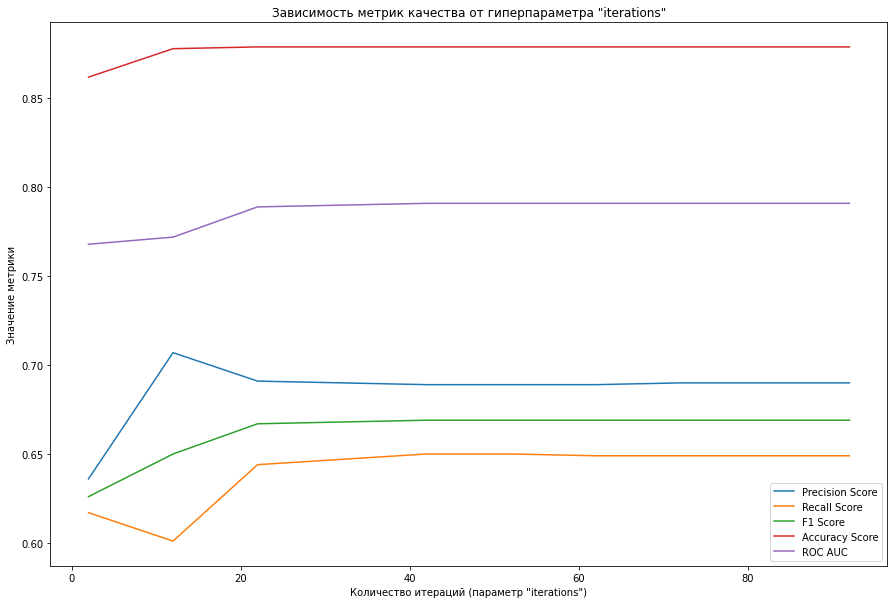

In [40]:
visualize_it(catboost_scores)

In [41]:
catboost_scores[catboost_scores['ROC AUC'] == catboost_scores['ROC AUC'].max()]

,Precision Score,Recall Score,F1 Score,Accuracy Score,ROC AUC
42,0.689,0.650,0.669,0.879,0.791
52,0.689,0.650,0.669,0.879,0.791
62,0.689,0.649,0.669,0.879,0.791
72,0.690,0.649,0.669,0.879,0.791
82,0.690,0.649,0.669,0.879,0.791
92,0.690,0.649,0.669,0.879,0.791


## Набор данных "Третья итерация"

In [ ]:
full_df = pd.read_csv('iteration3.csv')
full_df = full_df.drop(columns=list(full_df.columns)[:2])
full_df

In [ ]:
X1 = full_df.drop(columns=['CHURN'])
X1

In [ ]:
y1 = full_df['CHURN']
y1

In [ ]:
X, X_val, y, y_val = train_test_split(X1.drop(columns=['user_id']), y1, test_size=0.3, random_state=777)
X

In [ ]:
cat_col = []

In [ ]:
catboost_scores=catboost_it(X, y, X_val, y_val, 1, 100, 10, True, cat_col)

In [ ]:
visualize_it(catboost_scores)

In [ ]:
catboost_scores[catboost_scores['ROC AUC'] == catboost_scores['ROC AUC'].max()]